# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Schedule:
- Checkpoint Submission (DUE 03 October 2025 @ 11:59PM EST)
- Kaggle Submission (DUE 10 October 2025 @ 11:59PM EST | Slack Deadline is 17 October 2025 @ 11:59PM EST)
- Code Submission (DUE 12 October 2025 @ 11:59PM EST OR Day-of Slack submission)


## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [8]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

## Welcome to the World of Convolutions!
In the previous homework, you learned about Multi-Layer Perceptrons (MLPs), the foundation of deep learning. MLPs demonstrated how networks could learn to predict phonemes from speech data, understand patterns, and even approximate complex functions. However, as powerful as MLPs are, they can struggle when dealing with image data. Flattening images into 1D vectors loses spatial information, like how pixels relate to one another. That’s where Convolutional Neural Networks (CNNs) step in, preserving these relationships and taking us one step closer to designing models that "see" the world as we do.

In this homework, you’ll explore CNNs by working on face classification and verification tasks. Imagine training a model to identify a face from a set of known identities (classification) and then using the same model to decide whether two face images belong to the same person (verification).

For example, given a photo of your friend and a group photo, the classifier would identify your friend’s name, while the verifier would confirm whether two photos depict the same person, even if the person wasn’t part of the training data. CNNs make this possible by extracting hierarchical features from images—from edges and corners in early layers to complex patterns like facial features in deeper layers.

To succeed, you’ll need to understand the nuances of loss functions. Classification relies on Cross-Entropy Loss, which optimizes the model to predict the correct label. For verification, however, we care about embedding similarity. This is where Triplet Loss or** ArcFace Loss** comes in, pushing embeddings of the same person closer together while separating those of different individuals. For instance, a good verification system would ensure that photos of two siblings (often visually similar) are distinguishable in the embedding space, all while being robust to lighting or pose differences.

This homework will also emphasize the practical skills needed for real-world deep learning. You’ll preprocess images, apply data augmentation like flipping or cropping to make the model robust to shifts in the images, and experiment with CNN architectures such as ResNet or ConvNeXt. Along the way, you’ll see how designing a model for classification doesn’t automatically make it suitable for verification, teaching you the importance of aligning task objectives with the right loss function. By the end, you’ll have built a robust system that mimics cutting-edge face recognition applications, from unlocking smartphones to verifying IDs. Let’s take this exciting leap together!

# **SET-UP**


Join the kaggle competition first (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)

## **Colab Users**

#### Step 1: Environment Setup

In [9]:
!nvidia-smi # Run this to see what GPU you have

Sun Oct 12 20:29:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                On  |   00000000:40:00.0 Off |                    0 |
| N/A   39C    P0             88W /  400W |    1443MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [10]:
!pwd

/home/ai2c/785P2


#### Step 2: Get Data

In [11]:
proj_root = "/home/ai2c/785P2"
get_data = False

In [12]:
if get_data:
    !kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2025
    !unzip -qo '11785-hw-2-p-2-face-verification-fall-2025.zip' -d '/home/ai2c/785P2/data'

# Imports

## Use this for deterministic pytorch

In [13]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # use `:16:8` if you have a bad gpu

In [14]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import gc
# from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv
import time
import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [15]:
def set_seed(seed=0, deterministic=True):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # for multiple gpus

    if deterministic:
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # may slow down training a little
    else:
        torch.backends.cudnn.benchmark = True


# Config

### Notes:

- You will need to set the root path to your `hw2p2_data` folder in `data: root:`. This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/data/hw2p2_puru_aligned"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-2-p-2-face-verification-fall-2025/hw2p2_puru_aligned"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned"`

Kindly modify your configurations to suit your ablations and be keen to include your name.

In [58]:
config = {
    'Name': 'Yuri Xu',
    'batch_size': 512, # Increase this if your GPU can handle it
    'lr': 0.0075,
    'epochs': 40, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'seed':5330, # universal seed for training
    'augument': True,
    'optimizer':'AdamW',
    'scheduler':'PlateauLROnLoss',
    'loss':'Cross-Entropy',
    'cls_data_dir': "/home/ai2c/785P2/data/hw2p2_puru_aligned/cls_data/", 
    'ver_data_dir': "/home/ai2c/785P2/data/hw2p2_puru_aligned/ver_data/", 
    'val_pairs_file': "/home/ai2c/785P2/data/hw2p2_puru_aligned/val_pairs.txt",
    'test_pairs_file': "/home/ai2c/785P2/data/hw2p2_puru_aligned/test_pairs.txt", 
    'checkpoint_dir': "/home/ai2c/785P2/checkpoint/"    
}

In [17]:
set_seed(config['seed'])

# Dataset

In [18]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),
        # Convert PIL Image to tensor
        T.ToTensor(),
        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),                 # already probabilistic
            T.RandomApply([T.RandomRotation(degrees=15)], p=0.3),  # rotates a random angle in range
            T.RandomApply([T.RandomResizedCrop(size=image_size, scale=(0.8, 1.0))]),  # random crop
            T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)],p=0.6), # jitter
            T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p = 0.3) # blur
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


In [19]:
import torchvision.transforms.v2 as v2
from torch.utils.data import default_collate

cutmix = v2.CutMix(num_classes=config['num_classes'])
mixup = v2.MixUp(num_classes=config['num_classes'])
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

### batch dependent augmentations

In [20]:
import torchvision.transforms.v2 as v2
from torch.utils.data import default_collate

cutmix = v2.CutMix(num_classes=config['num_classes'])
mixup = v2.MixUp(num_classes=config['num_classes'])
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

## Classification Datasets and Dataloaders

In [21]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

0

In [22]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])
# val transforms
val_transforms   = create_transforms(augment=False)

/home/ai2c/785P2/venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
# Datasets
cls_train_dataset = ImageDataset(config['cls_data_dir']+"train",train_transforms)
# HINT: What dataset class do you use? What folder has your training data?
# What transforms should training data use?

cls_val_dataset   = ImageDataset(config['cls_data_dir']+"dev",val_transforms)
# HINT: Same dataset class, but what folder for validation?
# Should validation use augmentation transforms?

cls_test_dataset  = ImageDataset(config['cls_data_dir']+"test",val_transforms)
# HINT: What's the pattern here? What folder contains test data?

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"

Loading dataset:   0%|          | 0/431550 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

## Verification Dataset and Datatloaders

In [24]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [25]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [26]:
# Datasets
ver_val_dataset  = ImagePairDataset(config['ver_data_dir'],config['val_pairs_file'],val_transforms)
# HINT: What dataset class handles image pairs? What file lists the validation pairs?

ver_test_dataset = TestImagePairDataset(config['ver_data_dir'],config['test_pairs_file'],val_transforms)
# HINT: Same class, but what file has test pairs? Does it include labels?

Loading image pairs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading image pairs:   0%|          | 0/6000 [00:00<?, ?it/s]

# Create Dataloaders for Image Recognition

In [27]:
# Dataloaders
def worker_init_fn(worker_id):
    # different but reproducible seed per worker
    s = torch.initial_seed() % 2**32
    np.random.seed(s)
    random.seed(s)
    torch.manual_seed(s)
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS", "1")
    try: 
        torch.set_num_threads(1)
    except:
        pass
    

g = torch.Generator().manual_seed(config['seed'])

h_num = (7 * os.cpu_count()) // 8 
cls_train_loader = DataLoader(
    cls_train_dataset,
    collate_fn=collate_fn, 
    batch_size=config['batch_size'], 
    drop_last=True,
    shuffle=True,  
    num_workers = h_num, 
    pin_memory=True,
    prefetch_factor=256,
    generator=g,
    worker_init_fn=worker_init_fn,
    persistent_workers=True,
)

cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers = 8, pin_memory=True, worker_init_fn=worker_init_fn, persistent_workers=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers = 16, pin_memory=True, worker_init_fn=worker_init_fn,)

In [28]:
# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True,worker_init_fn=worker_init_fn)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True,worker_init_fn=worker_init_fn)

In [29]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("Number of classes    : ", len(ver_test_dataset.image1_list))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
Number of classes    :  6000
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  512
Train batches        :  842
Val batches          :  85


# EDA and Viz

### sample data (train,val)

In [30]:
cl_viz = False

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

# Base path for images
base_path = "data/hw2p2_puru_aligned/cls_data/train/images"

# List of files with their labels
files_with_labels = [
    ("train_000001.jpg", 0),
    ("train_000002.jpg", 0),
    ("train_000003.jpg", 0),
    ("train_000004.jpg", 0),
    ("train_000005.jpg", 0),
    ("train_000006.jpg", 0),
    ("train_000007.jpg", 0),
    ("train_000008.jpg", 0),
    ("train_000009.jpg", 0),
    ("train_000010.jpg", 0),
    ("train_000011.jpg", 0),
    ("train_000012.jpg", 0),
    ("train_000013.jpg", 0),
    ("train_000014.jpg", 0),
    ("train_000015.jpg", 0),
    ("train_000016.jpg", 0),
    ("train_000017.jpg", 0),
    ("train_000018.jpg", 0),
    ("train_000019.jpg", 0),
]
if cl_viz:
    # Compute grid size
    n = len(files_with_labels)
    cols = 5
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    for ax, (filename, label) in zip(axes.flatten(), files_with_labels):
        filepath = os.path.join(base_path, filename)
        try:
            img = Image.open(filepath)
            ax.imshow(img)
            ax.set_title(f"{filename}\nLabel: {label}", fontsize=8)
            ax.axis("off")
        except FileNotFoundError:
            ax.set_title(f"Missing: {filename}", fontsize=8)
            ax.axis("off")

    # Hide unused axes
    for ax in axes.flatten()[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### classification viz

In [32]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            #label = label.item()
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()
if cl_viz:
    show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

### Ver Dataset Viz

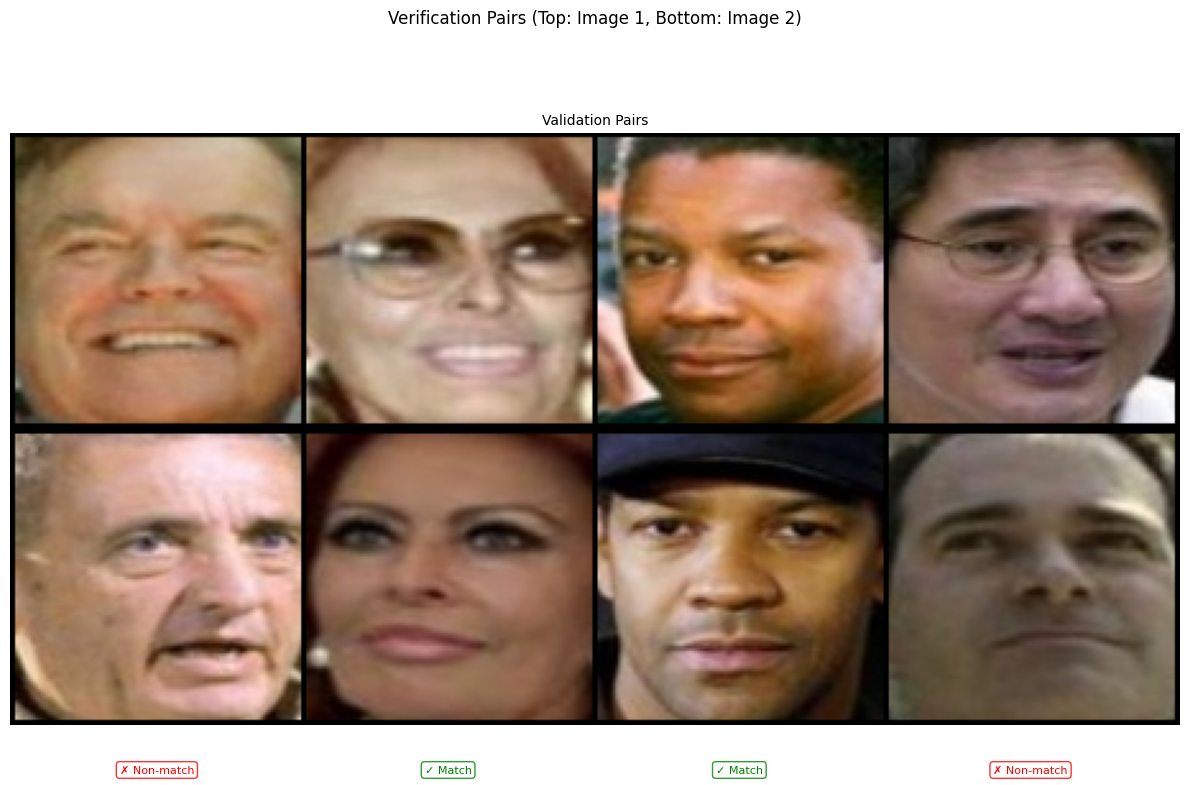

In [33]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

## Resnet

In [34]:
class First_Block(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_chan, out_chan, 3, 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_chan, out_chan, 3, 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_chan, out_chan, 3, 1, padding = 1, bias = False),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2 , padding = 1)
        )
    def forward(self,A):
        Z = self.block(A)
        return Z

In [35]:
class Res_Block(torch.nn.Module):
    expansion = 1
    def __init__(self, in_chan, out_chan, stride = 1):
        super().__init__()
        padding = 1 # ensure out_h = in_h
        self.stride = stride
        #! shortcut layer
        self.skip = None
        if (stride != 1) or (in_chan != out_chan):
            self.skip = torch.nn.Sequential(
                torch.nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_chan),
            )
        #! deep layers
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_chan, out_chan, 3, stride, padding, bias=False),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_chan, out_chan, 3, 1, padding, bias=False),
            torch.nn.BatchNorm2d(out_chan),
        )
        self.o_act = torch.nn.ReLU(inplace=True)
    def forward(self, A):
        shortcut = A
        Z = self.main(A)
        if self.skip is not None:
            shortcut = self.skip.forward(shortcut)
        Z += shortcut
        Z = self.o_act(Z)
        return Z

In [36]:
def stack_blocks(num_layers, in_chan, out_chan, stride = 1):
    layers = []
    layers.append(Res_Block(in_chan, out_chan, stride))
    for _ in range(num_layers-1):
        layers.append(Res_Block(out_chan, out_chan, stride = 1))
    return torch.nn.Sequential(*layers)

In [37]:
class Resnet34(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torch.nn.Sequential(
            First_Block(3,64),
            stack_blocks(3, 64, 64, stride = 1),
            stack_blocks(4, 64, 128, stride = 2),
            stack_blocks(6, 128, 256, stride = 2),
            stack_blocks(3, 256, 512, stride = 2),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
        )
        # linear layer
        self.cls_layer = torch.nn.Linear(512, num_classes)
        # Initialize the weights and biases of the linear layer
        torch.nn.init.normal_(self.cls_layer.weight, mean=0., std=0.01)
        torch.nn.init.constant_(self.cls_layer.bias, 0.)
    def forward(self,A):
        feats = self.backbone(A)
        out = self.cls_layer(feats)
        return {"feats": feats, "out": out}

## Model choices

In [38]:
# Initialize your model
model = Resnet34(num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))
assert(sum(p.numel() for p in model.parameters() if p.requires_grad) < 30000000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,728
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
      First_Block-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,864
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [39]:
import torch.nn as nn
import torchvision.models as tv

class ResNet34Scratch(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Build from scratch, no pretrained
        try:
            m = tv.resnet34(weights=None, num_classes=num_classes)
        except TypeError:
            m = tv.resnet34(weights=None)
            m.fc = nn.Linear(m.fc.in_features, num_classes)

        # Expose pooled features + logits (like your custom model)
        self.backbone = nn.Sequential(*(list(m.children())[:-1]))  # up to avgpool
        self.cls_layer = m.fc

        # Optional: init head like torchvision
        nn.init.normal_(self.cls_layer.weight, mean=0.0, std=0.01)
        if self.cls_layer.bias is not None:
            nn.init.zeros_(self.cls_layer.bias)

    def forward(self, x):
        feats = self.backbone(x).flatten(1)  # [B, 512]
        logits = self.cls_layer(feats)       # [B, num_classes]
        return {"feats": feats, "out": logits}


In [40]:
# --------------------------------------------------- #

# Defining Loss function
#criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?
criterion = torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, size_average=None, reduce=None, reduction='mean')
# --------------------------------------------------- #

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])  # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor = 0.3, patience = 5, min_lr=1e-6)

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Metrics

In [41]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [43]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

In [44]:
class TripletImageDataset(torch.utils.data.Dataset):
    """Dataset that generates triplets for triplet loss"""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()
        
        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading images"):
            img_path, label = line.strip().split(' ')
            if int(label) < num_classes:  # Keep only first num_classes
                self.image_paths.append(os.path.join(self.root, img_path))
                self.labels.append(int(label))
                self.classes.add(int(label))

        self.classes = sorted(list(self.classes))
        self.num_classes = len(self.classes)
        
        # Create label to indices mapping for efficient triplet sampling
        self.label_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get anchor
        anchor_path = self.image_paths[idx]
        anchor_label = self.labels[idx]
        anchor_img = Image.open(anchor_path).convert('RGB')
        
        # Get positive (same class, different sample)
        positive_indices = self.label_to_indices[anchor_label].copy()
        positive_indices.remove(idx)  # Remove anchor itself
        if len(positive_indices) == 0:
            # If no other positive samples, use the anchor itself
            positive_idx = idx
        else:
            positive_idx = random.choice(positive_indices)
        positive_path = self.image_paths[positive_idx]
        positive_img = Image.open(positive_path).convert('RGB')
        
        # Get negative (different class)
        negative_labels = [l for l in self.classes if l != anchor_label]
        negative_label = random.choice(negative_labels)
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_path = self.image_paths[negative_idx]
        negative_img = Image.open(negative_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img, anchor_label

In [45]:
def train_epoch_triplet(model, dataloader, optimizer, lr_scheduler, scaler, device, config):
    """Training function specifically for triplet loss"""
    model.train()

    # metric meters
    loss_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()

        if len(batch) == 4:  # Triplet dataset: (anchor, positive, negative, labels)
            anchor_imgs, positive_imgs, negative_imgs, labels = batch
            
            # Send to device
            anchor_imgs = anchor_imgs.to(device, non_blocking=True)
            positive_imgs = positive_imgs.to(device, non_blocking=True)
            negative_imgs = negative_imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            with torch.amp.autocast('cuda', enabled=True):
                anchor_outputs = model(anchor_imgs)
                positive_outputs = model(positive_imgs)
                negative_outputs = model(negative_imgs)

                # Use features (embeddings) for triplet loss, not logits
                anchor_feats = anchor_outputs['feats']
                positive_feats = positive_outputs['feats'] 
                negative_feats = negative_outputs['feats']

                # Triplet loss
                loss = criterion(anchor_feats, positive_feats, negative_feats)

        else:  # Regular dataset: (images, labels) - need to create triplets on-the-fly
            images, labels = batch
            images = images.to(device, non_blocking=True)
            if isinstance(labels, (tuple, list)):
                # Handle CutMix/MixUp labels - just use the first target for triplet creation
                targets1, targets2, lam = labels
                labels = targets1
            labels = labels.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=True):
                outputs = model(images)
                
                # Create triplets from batch (hard negative mining could be added here)
                anchor_feats, positive_feats, negative_feats = create_triplets_from_batch(
                    outputs['feats'], labels
                )
                
                loss = criterion(anchor_feats, positive_feats, negative_feats)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # metrics
        loss_m.update(loss.item())

        # tqdm updates
        batch_bar.set_postfix(
            loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()

    batch_bar.close()
    return 0.0, loss_m.avg  # No accuracy for triplet loss

def create_triplets_from_batch(features, labels):
    """Create triplets from a batch of features and labels"""
    batch_size = features.size(0)
    anchors, positives, negatives = [], [], []
    
    for i in range(batch_size):
        anchor_label = labels[i]
        
        # Find positive (same class, different sample)
        positive_indices = (labels == anchor_label).nonzero(as_tuple=True)[0]
        positive_indices = positive_indices[positive_indices != i]  # Remove anchor
        if len(positive_indices) > 0:
            pos_idx = positive_indices[torch.randint(len(positive_indices), (1,)).item()]
        else:
            pos_idx = i  # Use anchor if no other positive
            
        # Find negative (different class)
        negative_indices = (labels != anchor_label).nonzero(as_tuple=True)[0]
        if len(negative_indices) > 0:
            neg_idx = negative_indices[torch.randint(len(negative_indices), (1,)).item()]
        else:
            neg_idx = (i + 1) % batch_size  # Fallback
            
        anchors.append(features[i])
        positives.append(features[pos_idx])
        negatives.append(features[neg_idx])
    
    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

# Train and Validation Function

In [46]:
def mixed_accuracy(output, labels, topk=(1,)):
    """
    Compute accuracy that can handle regular labels, mixed labels, and one-hot encoded labels
    """
    if isinstance(labels, (tuple, list)):
        # Mixed labels from CutMix/MixUp: (targets1, targets2, lam)
        targets1, targets2, lam = labels
        # For accuracy, use the dominant target (the one with higher lambda)
        if lam >= 0.5:
            target = targets1
        else:
            target = targets2
    elif labels.dim() > 1 and labels.size(1) > 1:
        # One-hot or probability distribution labels - convert to class indices
        target = torch.argmax(labels, dim=1)
    else:
        target = labels
    
    # Now compute accuracy normally with the selected target
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [47]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.amp.autocast('cuda', enabled=True):  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = mixed_accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    # if lr_scheduler is not None:
    #     lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [48]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):
    """Classification validation function that works with triplet loss training"""
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # Use CrossEntropyLoss for validation since triplet loss doesn't make sense for classification accuracy
    val_criterion = torch.nn.CrossEntropyLoss()
    
    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            # Use classification loss for validation, not triplet loss
            loss = val_criterion(outputs['out'], labels)

        # metrics
        acc = mixed_accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

@torch.no_grad()
def valid_epoch_ver(model, pair_data_loader, device, config):
    """Verification validation function for face verification pairs"""
    model.eval()
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Ver.', ncols=5)

    # metric meters  
    loss_m = AverageMeter()
    
    # For verification, we collect similarities and labels
    all_similarities = []
    all_labels = []

    for i, (images1, images2, match_labels) in enumerate(pair_data_loader):
        # Move to device
        images1 = images1.to(device, non_blocking=True)
        images2 = images2.to(device, non_blocking=True)
        match_labels = match_labels.to(device, non_blocking=True)

        with torch.inference_mode():
            # Get embeddings for both images
            outputs1 = model(images1)
            outputs2 = model(images2)
            
            embeddings1 = outputs1['feats']
            embeddings2 = outputs2['feats']
            
            # Calculate cosine similarity
            embeddings1 = torch.nn.functional.normalize(embeddings1, p=2, dim=1)
            embeddings2 = torch.nn.functional.normalize(embeddings2, p=2, dim=1)
            similarities = torch.sum(embeddings1 * embeddings2, dim=1)
            
            # For loss, we can use a simple similarity-based loss or skip it
            # Here we'll compute a simple contrastive-like loss
            target_similarities = match_labels.float() * 2 - 1  # Convert 0/1 to -1/1
            loss = torch.nn.functional.mse_loss(similarities, target_similarities)

        # Store for metric calculation
        all_similarities.extend(similarities.cpu().numpy())
        all_labels.extend(match_labels.cpu().numpy())
        
        loss_m.update(loss.item())

        batch_bar.set_postfix(
            loss = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    
    # Calculate verification metrics (EER, accuracy)
    similarities = np.array(all_similarities)
    labels = np.array(all_labels)
    
    # Convert similarities to distances for EER calculation
    distances = 1 - similarities
    
    # Calculate EER and other metrics
    metrics = get_ver_metrics(labels.tolist(), similarities.tolist(), [0.001, 0.01, 0.1])
    eer = metrics['EER']
    acc = metrics['ACC']
    
    return acc, loss_m.avg, eer

In [49]:
import numpy as np

In [50]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [51]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [45]:
wandb.login(key="6a5e9e17ff896e3de5cfa7a583ac41019f68004b") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ai2c/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /home/ai2c/.netrc
wandb: Currently logged in as: yuriishida (yuriishida-p1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: yuriishida (yuriishida-p1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [46]:
# Create your wandb run
run = wandb.init(
    name = "bs_2_1", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-determinstic", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Checkpointing and Loading Model

In [47]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [48]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [49]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/home/ai2c/785P2/wandb/run-20251010_175048-80fqw3ja/files/model_arch.txt']

In [50]:
### Save augmentations used
augs = ['default']
with open("augmentations.txt", "w") as f:
    f.writelines(f"{aug}\n" for aug in augs)

### log it in your wandb run with wandb.save()
wandb.save('augmentations.txt')

['/home/ai2c/785P2/wandb/run-20251010_175048-80fqw3ja/files/augmentations.txt']

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
best_eer = float('inf') 
eval_cls = True

for epoch in range(e, config['epochs']):
    start_time = time.time()
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    # reseed dataloader shuffling when using persistent workers
    g.manual_seed(config['seed'] + epoch)

    # ---- train ----
    train_cls_acc, train_loss = train_epoch_triplet(
        model, cls_train_loader, optimizer, None, scaler, DEVICE, config
    )  # Use triplet training function
    # ---- validate ----
    if eval_cls:
        valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
        print(f"Val Cls. Acc {valid_cls_acc:.04f}%\t Val Cls. Loss {valid_loss:.04f}")
    else:
        valid_cls_acc, valid_loss = None, None

    # Updated to handle 3 return values: accuracy, loss, eer
    valid_ret_acc, eer = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
    print(f"Val Ret. Acc {valid_ret_acc:.04f}%\t EER {eer:.06f}")

    # ---- step ReduceLROnPlateau on the metric you care about ----
    # EER: lower is better -> mode='min' (set in ctor)
    scheduler.step(eer)

    # read *post-step* LR
    curr_lr = float(optimizer.param_groups[0]['lr'])

    # timing (sync for accurate CUDA timing)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    print(f"Epoch Time: {end_time - start_time:.2f} seconds | LR: {curr_lr:.8f}")

    # ---- logging to wandb ----  
    run.log({
        "train_cls_acc": train_cls_acc,
        "train_loss": train_loss,
        "valid_cls_acc": valid_cls_acc if valid_cls_acc is not None else 0,
        "valid_loss": valid_loss if valid_loss is not None else 0,
        "valid_ret_acc": valid_ret_acc,
        "eer": eer,
        "epoch_time": end_time,
        "lr": curr_lr
    })

    # ---- checkpointing ----
    if eer < best_eer:
        best_eer = eer
        best_valid_cls_acc = valid_cls_acc if valid_cls_acc is not None else 0
        # save best model based on EER
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_ret.pth'))

    if eval_cls and valid_cls_acc is not None and valid_cls_acc > best_valid_cls_acc:
        best_valid_cls_acc = valid_cls_acc
        # save best model based on classification accuracy  
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_cls.pth'))

print(f"Best EER: {best_eer:.6f}")
print(f"Best Valid Cls Acc: {best_valid_cls_acc:.4f}%")


Epoch 1/50


Train:   0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
break

# Testing and Kaggle Submission

In [52]:
#checkpoint_file = wandb.restore('checkpoint/best_ret.pth', run_path="yuriishida-p1/hw2p2-ablations/u23rc1k4").name 
checkpoint_file = "epoch_31.pth"
checkpoint_dict = torch.load(checkpoint_file,weights_only=False) 
model.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [53]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [54]:
scores = test_epoch_ver(model, ver_test_loader, config)

Val Veri.:   0%|          | 0/12 [00:00<?, ?it/s]

In [55]:
with open("verification_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
running = False
if running:
    run.finish()

**For Kaggle users:**

You'll find the "**verification_submission.csv**" under the **right sidebar → Output → kaggle/working/**.
If you don't see it immediately, click the refresh icon in the top-right corner.
Once located, **right-click → Download**, and then manually upload the file to the Kaggle competition submission page.

**For Colab and PSC users**, run the following blocks:

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
! KAGGLE_CONFIG_DIR=.kaggle kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2025 -f verification_submission.csv -m "Test Submission"

In [ ]:
# If you need to download the CSV and submit manually, uncomment the appropriate section below.

# #Colab users:
# from google.colab import files
# files.download("verification_submission.csv")

# #PSC users:
# Download the file manually:
# # Navigate to the left sidebar → locate the file in "/jet/home/<your_username>"
# # Right-click the file and select "Download".
# # If you don't see it immediately, try refreshing the file browser.

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [60]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission ater.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"OK: Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"OK: Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"OK: saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)
#### IMPORTANT: Do NOT change the name of the model_metadata_....json file!!

OK: saved model data saved to: 'model_metadata_2025-10-12_20-31.json'
REQUIRED to submit to Autolab if these are the best model weights.


## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following our setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/<your_username>/..."` You can check the files in this path by running: ```!ls /jet/home/<your_username>/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [61]:
####################################
#             README
####################################

# TODO: Please complete all components of this README
README = """
- **Model**: Model archtiecture description. Anything unique? Any specific architecture shapes or strategies?
- **Training Strategy**: optimizer + scheduler + loss function + any other unique ideas
- **Augmentations**: augmentations if used. If augmentations weren't used, then ignore
- **Notebook Execution**: Any instructions required to run your notebook.
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

KAGGLE_USERNAME = "yurixu1234" #TODO
KAGGLE_API_KEY = "590967e22cec98434887f430633534a9" #TODO
WANDB_API_KEY = "6a5e9e17ff896e3de5cfa7a583ac41019f68004b" #TODO


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "yuriishida-p1" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "hw2p2-determinstic" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW2P2 Notebook (if on colab or kaggle) and upload both your HW2P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.

# TODO: KAGGLE INSTRUCTIONS:
# * First download a copy of your notebook with "File > Download Notebook"
# Then...
# * Click "File" in the top left of the screen
# * Go to "Upload Input > Upload Model"
# * Upload your notebook file.
# * For "Model Name" put HW2P2_Final_Submission
# * For "Framework" put "Other"
# * For "License" put "Other"
# * Click "Upload another file" and upload your model_metadata####.json file as well.
# * Now, on your right in your "Models" section, you should see a new folder with your submission files.
# * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.

# TODO: Linux system:
# * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

NOTEBOOK_PATH = "/home/ai2c/785P2/det_arch21.ipynb" # TODO: Put your HW2P2 notebook path here
MODEL_METADATA_JSON = "/home/ai2c/785P2/model_metadata_2025-10-12_20-31.json" # TODO: Put your Model Metadata path json file here (see end of HW2P2 Code Notebook to get this file)


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True


# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [62]:
from datetime import datetime

######################################
#       Assignment Configs
######################################

WANDB_METRIC = "EER"
WANDB_DIRECTION = "descending"
WANDB_TOP_N = 10
WANDB_OUTPUT_PKL = "wandb_top_runs.pkl"

# Kaggle configuration
COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025"
SLACK_COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025-slack"
INAL_SUBMISSION_DATETIME = datetime.strptime("2025-10-12 23:55:00", "%Y-%m-%d %H:%M:%S")
SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-10-17 23:55:00", "%Y-%m-%d %H:%M:%S")
GRADING_DIRECTION = "descending"
KAGGLE_OUTPUT_JSON = "kaggle_data.json"

SUBMISSION_OUTPUT = "HW2P2_final_submission.zip"

In [63]:
FINAL_SUBMISSION_DATETIME = str(datetime.strptime("2025-10-12 23:55:00", "%Y-%m-%d %H:%M:%S")) # converting to string

SLACK_SUBMISSION_DATETIME = str(datetime.strptime("2025-10-17 23:55:00", "%Y-%m-%d %H:%M:%S")) # converting to string

In [ ]:
from datetime import datetime, timezone
import zoneinfo

eastern = zoneinfo.ZoneInfo("America/New_York")
FINAL_DEADLINE_UTC = (
    datetime.strptime(FINAL_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
    .replace(tzinfo=eastern)
    .astimezone(timezone.utc)
)

SLACK_DEADLINE_UTC = (
    datetime.strptime(SLACK_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
    .replace(tzinfo=eastern)
    .astimezone(timezone.utc)
)

ACKNOWLEDGEMENT_MESSAGE = """
Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
"""
def save_acknowledgment_file():
    if ACKNOWLEDGED:
        with open("acknowledgement.txt", "w") as f:
            f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
        print("Saved acknowledgement.txt")
        return True
    else:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False
# Saves README
def save_readme(readme):
    try:
        with open("README.txt", "w") as f:
            f.write(readme.strip())

        print("Saved README.txt")
    except Exception as e:
        print(f"ERROR: Error occured while saving README.txt: {e}")
        return False

    return True

# Saves wandb logs
import wandb, json, pickle

def save_top_wandb_runs():
    wandb.login(key=WANDB_API_KEY)
    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    api = wandb.Api()
    runs = api.runs(
        f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
        order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
    )
    print("the length of runs",len(runs))
    selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

    if not selected_runs:
        print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
        return False

    all_data = []
    for run in selected_runs:
        run_data = {
            "id": run.id,
            "name": run.name,
            "tags": run.tags,
            "state": run.state,
            "created_at": str(run.created_at),
            "config": run.config,
            "summary": run.summary,
        }
        try:
            run_data["history"] = run.history(samples=1000)
        except Exception as e:
            run_data["history"] = f"Failed to fetch history: {str(e)}"
        all_data.append(run_data)
    with open(WANDB_OUTPUT_PKL, "wb") as f:
        pickle.dump(all_data, f)

    print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

    return True
# Saves kaggle information

# Install dependencies silently (only if running on Colab)
import sys

from datetime import datetime
import os, json, requests
def kaggle_login(username, key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump({"username": username, "key": key}, f)
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


def get_active_submission_config():
    if ENABLE_SLACK_SUBMISSION:
        return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
    return COMPETITION_NAME, FINAL_DEADLINE_UTC

def kaggle_user_exists(usernagbme):
    try:
        return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
    except Exception as e:
        print(f"ERROR: Error occured while checking Kaggle user: {e}")
        return False

DEFAULT_SCORE=0
if GRADING_DIRECTION == "ascending":
    DEFAULT_SCORE=0
else:
    DEFAULT_SCORE=1.0

def get_best_kaggle_score(subs):
    def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
    if not subs:
        return None, None
    best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))

    score_type = "private" if best.private_score not in [None, ""] else "public"
    return extract_score(best), score_type

def save_kaggle_json(kaggle_username, kaggle_key):

    kaggle_login(kaggle_username, kaggle_key)

    from kaggle.api.kaggle_api_extended import KaggleApi

    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    if not kaggle_user_exists(KAGGLE_USERNAME):
        print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
        return False

    comp_name, deadline = get_active_submission_config()

    api = KaggleApi()
    api.authenticate()

    # Get competition submissions
    submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "_submitted_by", None) == KAGGLE_USERNAME]
    if not submissions:
        print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
        print("Please double check your Kaggle username and ensure you've submitted at least once.")
        return False

    score, score_type = get_best_kaggle_score(submissions)
    result = {
        "kaggle_username": KAGGLE_USERNAME,
        "acknowledgement": ACKNOWLEDGED,
        "submitted_slack": ENABLE_SLACK_SUBMISSION,
        "competition_name": comp_name,
        "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
        "raw_score": score * 100.0,
        "score_type": score_type,
    }

    print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
    if score:
        print(f"Best score {score}.")
        with open(KAGGLE_OUTPUT_JSON, "w") as f:
            json.dump(result, f, indent=2)
        return True
    return False

import os
import sys
import zipfile


def create_submission_zip(additional_files, safe_flag):
    if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if (not save_acknowledgment_file()):
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return


    if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
        print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
        return

    if not "README" in globals() or not README:
        print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
        return

    if (not save_readme(README)):
        print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
        return

    if (not save_top_wandb_runs()):
        return

    if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
        print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
        return

    if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
        print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
        return

    files_to_zip = [
        "acknowledgement.txt",
        "README.txt",
        KAGGLE_OUTPUT_JSON,
        WANDB_OUTPUT_PKL,
        MODEL_METADATA_JSON,
        NOTEBOOK_PATH,
    ] + additional_files

    missing_files = False

    with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)  # flatten path
                zipf.write(file_path, arcname=arcname)
                print(f"OK: Added {arcname}")
            else:
                missing_files = True
                print(f"ERROR: Missing file: {file_path}")

    if missing_files:
        if safe_flag:
            raise "ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells."
        else:
            print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

    if "google.colab" in sys.modules:
        from google.colab import files
        files.download(SUBMISSION_OUTPUT)

    print("Final submission saved as:", SUBMISSION_OUTPUT)

In [77]:
wandb.login(key=WANDB_API_KEY)
if not ACKNOWLEDGED:
    print("ERROR: Must set ACKNOWLEDGED = True.")
    

api = wandb.Api()
runs = api.runs(
    f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
    order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
)
print("the length of runs",len(runs))
selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

if not selected_runs:
    print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
 

all_data = []
for run in selected_runs:
    print(run)
    print(run.id)
    print(run.tags)
    print(run.state)
    #print(run.summary)
    run_data = {
        "id": run.id,
        "name": run.name,
        "tags": run.tags,
        "state": run.state,
        "created_at": str(run.created_at),
        "config": run.config,
        "summary": run.summary,
    }
    try:
        run_data["history"] = run.history(samples=1000)
    except Exception as e:
        run_data["history"] = f"Failed to fetch history: {str(e)}"
    all_data.append(run_data)
with open(WANDB_OUTPUT_PKL, "wb") as f:
    pickle.dump(all_data, f)

print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ai2c/.netrc


the length of runs 25
<Run yuriishida-p1/hw2p2-determinstic/0tu2wbiz (crashed)>
0tu2wbiz
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/3pcmpexg (crashed)>
3pcmpexg
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/60gxpgf1 (crashed)>
60gxpgf1
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/7m0ud0l0 (crashed)>
7m0ud0l0
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/80fqw3ja (crashed)>
80fqw3ja
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/80wua0zt (crashed)>
80wua0zt
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/86aj2vyn (crashed)>
86aj2vyn
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/auj6oc79 (crashed)>
auj6oc79
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/fur3zjcb (crashed)>
fur3zjcb
[]
crashed
<Run yuriishida-p1/hw2p2-determinstic/h6kltllf (finished)>
h6kltllf
[]
finished
OK: Exported 10 WandB runs to wandb_top_runs.pkl


# File Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [65]:
create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW2P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to entire the files and
#manually download the checkpoint_submission.json file.

Saved acknowledgement.txt
Saved README.txt


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ai2c/.netrc
wandb: Currently logged in as: yuriishida (yuriishida-p1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


AttributeError: 'str' object has no attribute 'keys'

### For Kaggle users:
Manually download the "**HW2P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.

